## Config

In [151]:
# used factor files
FACTOR_1_PATH = "../../data/processed/emigratie.csv"
FACTOR_2_PATH = "../../data/processed/immigratie.csv"
FACTOR_3_PATH = "../../data/processed/leefbarometer_clean.csv"
FACTOR_4_PATH = "../../data/processed/woningvoorraad.csv"
FACTOR_5_PATH = "../../data/processed/vergrijzing.csv"
FACTOR_6_PATH = "../../data/processed/verkoopprijzen.csv"
FACTOR_7_PATH = "../../data/processed/vertek_gm.csv"
FACTOR_8_PATH = "../../data/processed/vestiging_gm.csv"
FACTOR_9_PATH = "../../data/processed/woonquote.csv"
FACTOR_10_PATH = "../../data/processed/huishoudens_clean.csv"
FACTOR_11_PATH = "../../data/processed/huurverhoging.csv"
PREDICTIONS_PATH = "../../data/processed/predictions.csv"

# set true or false
SAVE_OUTPUT = False
# change to filename
OUTPUT_DATA_PATH = "data/processed/filename.csv"

In [152]:
import os
from os import getcwd

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from branca.element import Figure

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', None)

## Load data

In [153]:
# load data
df_emigratie = pd.read_csv(FACTOR_1_PATH, sep = ';')
df_immigratie = pd.read_csv(FACTOR_2_PATH, sep = ';')
df_leefbarometer = pd.read_csv(FACTOR_3_PATH, sep = ';')
df_woningvoorraad = pd.read_csv(FACTOR_4_PATH, sep = ';')
df_vergrijzing = pd.read_csv(FACTOR_5_PATH, sep = ';')
df_verkoopprijzen = pd.read_csv(FACTOR_6_PATH, sep = ';')
df_vertek_gm = pd.read_csv(FACTOR_7_PATH, sep = ';')
df_vestiging_gm = pd.read_csv(FACTOR_8_PATH, sep = ';')
df_woonquote = pd.read_csv(FACTOR_9_PATH, sep = ';')
df_huishoudens = pd.read_csv(FACTOR_10_PATH, sep = ';')
df_huurverhoging = pd.read_csv(FACTOR_11_PATH, sep = ';')
df_predictions = pd.read_csv(PREDICTIONS_PATH, sep = ';')

## Data management

In [154]:
# List of all data frames
dataframes = [
    df_emigratie, df_immigratie, df_leefbarometer, df_woningvoorraad,
    df_vergrijzing, df_verkoopprijzen, df_vertek_gm, df_vestiging_gm,
    df_woonquote, df_huishoudens, df_huurverhoging
]

# Extract year columns for each data frame (excluding non-year columns such as municipality names)
jaarsets = [set(df.columns) for df in dataframes]

# Find overlapping years
overlappende_jaren = set.intersection(*jaarsets)

print("Overlappende jaren in alle datasets:", overlappende_jaren)

Overlappende jaren in alle datasets: {'2018', '2020', 'gm_code', 'gm_naam', '2022'}


Because the Living Barometer misses many intervening years, this data is interpolated.

In [155]:
# List the current year columns
jaarkolommen = [col for col in df_leefbarometer.columns if col.isdigit()]

# Create a full range of years (e.g., 2002 to 2022)
volledige_jaren = list(range(int(min(jaarkolommen)), int(max(jaarkolommen)) + 1))

# Add missing year columns to the dataframe
for jaar in volledige_jaren:
    if str(jaar) not in df_leefbarometer.columns:
        df_leefbarometer[str(jaar)] = None

# Sort columns so that year columns are in order
niet_jaarkolommen = [col for col in df_leefbarometer.columns if not col.isdigit()]
kolom_volgorde = niet_jaarkolommen + sorted([col for col in df_leefbarometer.columns if col.isdigit()], key=int)
df_leefbarometer = df_leefbarometer[kolom_volgorde]

# Interpolate values for the missing year columns
df_leefbarometer.iloc[:, len(niet_jaarkolommen):] = (
    df_leefbarometer.iloc[:, len(niet_jaarkolommen):]
    .astype(float)
    .interpolate(axis=1)  # Interpolate along the columns (horizontal)
)


In [156]:
# List of all data frames
dataframes = [
    df_emigratie, df_immigratie, df_leefbarometer, df_woningvoorraad,
    df_vergrijzing, df_verkoopprijzen, df_vertek_gm, df_vestiging_gm,
    df_woonquote, df_huishoudens, df_huurverhoging
]

# Extract year columns for each data frame (excluding non-year columns such as municipality names)
jaarsets = [set(df.columns) for df in dataframes]

# Find overlapping years
overlappende_jaren = set.intersection(*jaarsets)

print("Overlapping years in all datasets:", overlappende_jaren)

Overlapping years in all datasets: {'2018', '2020', 'gm_code', 'gm_naam', '2021', '2022', '2019'}


Now we have several years of which we have all the dates (2018-2022)

In [157]:
# use one of the df's to make a fixed sequence of the gm_codes
for df in dataframes:
    df.sort_values(by='gm_code', inplace=True)

In [158]:
df_predictions.sort_values(by='gm_code', inplace=True)

In [159]:
print("Kolomnamen in dataframe:", df_emigratie.columns)

Kolomnamen in dataframe: Index(['gm_naam', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021', '2022', '2023', 'gm_code', 'geometry'],
      dtype='object')


In [160]:
df_emigratie.columns = df_emigratie.columns.astype(str)

df_emigratie["2018"]

In [161]:
# List of all data frames and their names
dataframes = {
    "emigratie": df_emigratie,
    "immigratie": df_immigratie,
    "leefbarometer": df_leefbarometer,
    "woningvoorraad": df_woningvoorraad,
    "vergrijzing": df_vergrijzing,
    "verkoopprijzen": df_verkoopprijzen,
    "vertek_gm": df_vertek_gm,
    "vestiging_gm": df_vestiging_gm,
    "woonquote": df_woonquote,
    "huishoudens": df_huishoudens,
    "huurverhoging": df_huurverhoging,
}
#Empty 2018 data frame
df_2018 = pd.DataFrame()

for name, df in dataframes.items():
    # Convert column names to strings
    df.columns = df.columns.astype(str)

    # Add column "2018" to the new data frame with a new column name
    df_2018[name] = df['2018']

# Empty 2022 data frame
df_2022 = pd.DataFrame()

for name, df in dataframes.items():
    # Convert column names to strings
    df.columns = df.columns.astype(str)

    # Add column "2018" to the new data frame with a new column name
    df_2022[name] = df['2022']

df_2018['gm_code'] = df_predictions['gm_naam']
df_2022['gm_code'] = df_predictions['gm_naam']
df_2022['geometry'] = df_woningvoorraad['geometry']

## Explorting Data

Explore how the relative change in leefbarometer associates with the relative change in real-estate prices (i.e. use **percentages**), using a scatter plot.

In [162]:
df_2022[df_2022["gm_code"] == 'Amsterdam']

,emigratie,immigratie,leefbarometer,woningvoorraad,vergrijzing,verkoopprijzen,vertek_gm,vestiging_gm,woonquote,huishoudens,huurverhoging,gm_code,geometry
109,22650.0,49516.0,4.188172,916794.0,17.746479,620954.0,55040.0,39111.0,799.333333,26471.0,3.3,Amsterdam,MULTIPOLYGON (((4.980683871849212 52.330760922...


Text(0, 0.5, 'verkoopprijzen')

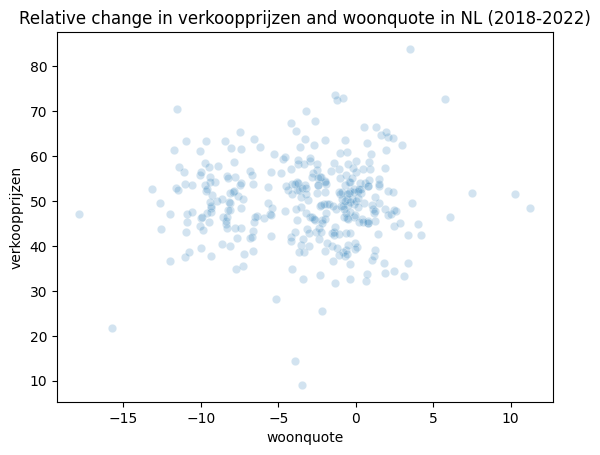

In [163]:
# creating relative change variable of prive and lbm
df_2022["rel_verkoopprijzen"] = ((df_2022["verkoopprijzen"]-df_2018["verkoopprijzen"])/df_2018["verkoopprijzen"])*100
df_2022["rel_woonquote"] = ((df_2022["woonquote"]-df_2018["woonquote"])/df_2018["woonquote"])*100

# plotting
sns.scatterplot(x = df_2022["rel_woonquote"], y = df_2022["rel_verkoopprijzen"], alpha = 0.2)
plt.title("Relative change in verkoopprijzen and woonquote in NL (2018-2022)")
plt.xlabel("woonquote")
plt.ylabel("verkoopprijzen")

In [164]:
df_2022['rel_verkoopprijzen'].describe()

count    332.000000
mean      49.741980
std        9.118636
min        9.061281
25%       44.785158
50%       49.566137
75%       54.988748
max       83.884423
Name: rel_verkoopprijzen, dtype: float64

In [165]:
# Count NaNs by region and sort
sorted_na_regions = (
    df_2022.isna()
    .groupby(df_2022['gm_code'])
    .sum()
    .sum(axis=1)
    .sort_values(ascending=False)
)

# View the top 36 regions with the most NaN values
sorted_na_regions.head(20)

gm_code
Langedijk              10
Delfzijl               10
Haaren                 10
Beemster               10
Cuijk                  10
Landerd                10
Grave                  10
Uden                   10
Appingedam             10
Loppersum              10
Mill en Sint Hubert    10
Heerhugowaard          10
Boxmeer                10
Sint Anthonis          10
Weesp                   4
Het Hogeland            3
Vijfheerenlanden        3
Beekdaelen              3
Noardeast-Fryslân       3
West Betuwe             3
dtype: int64

In [166]:
df_2018_regres = df_2018.drop(columns = ["gm_code"])

df_2018_filled = df_2018_regres.fillna(df_2018_regres.median())
df_2022_filled = df_2022.fillna(df_2018_regres.median())

In [167]:
from shapely import wkt

In [168]:
df_2018['geometry'] = df_woningvoorraad['geometry']
df_2018['geometry'] = df_2018['geometry'].apply(wkt.loads)

gdf_2018 = gpd.GeoDataFrame(df_2018, geometry='geometry')

In [169]:
from shapely import wkt
df_2022['geometry'] = df_2022['geometry'].apply(wkt.loads)

# creating geopanda dataframe
gdf_2022 = gpd.GeoDataFrame(df_2022, geometry='geometry')

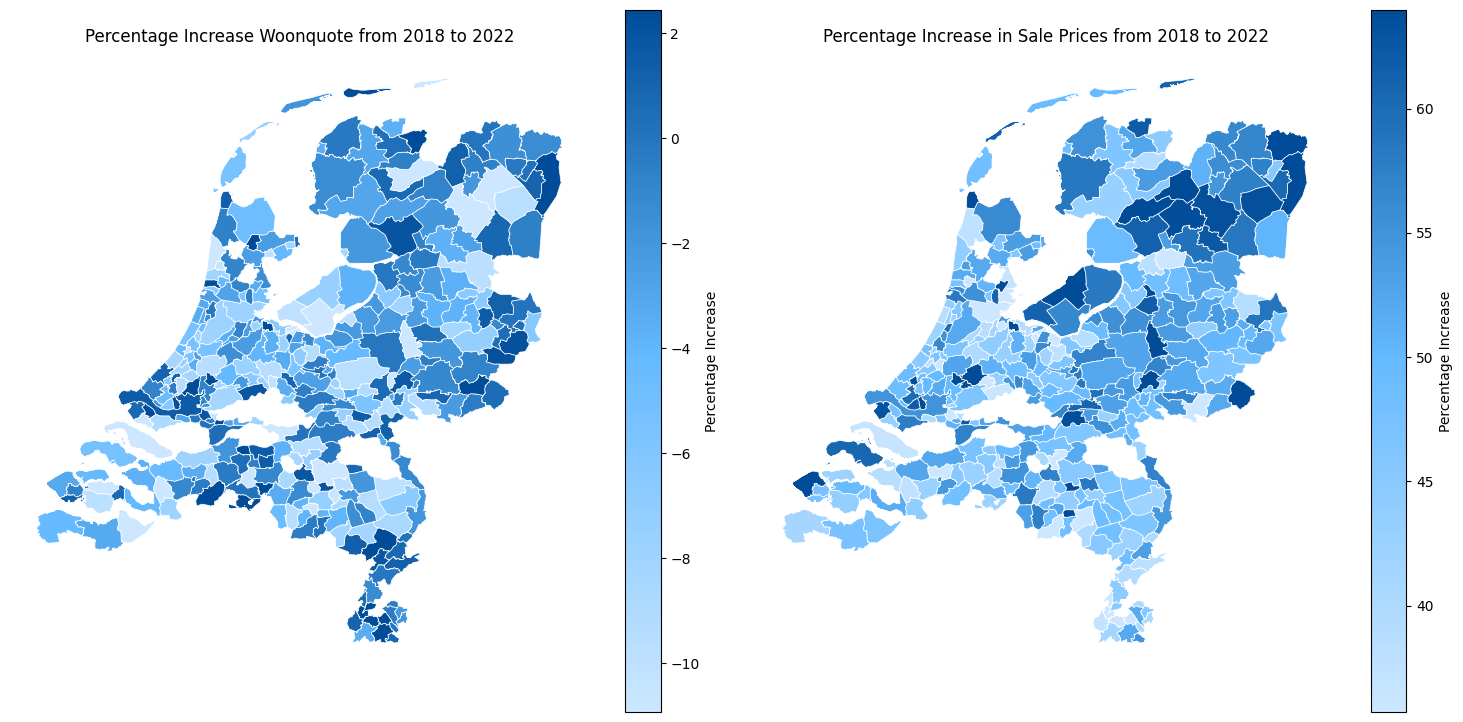

In [170]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Custom colormap using continuous lighter blue shades
cmap = mcolors.LinearSegmentedColormap.from_list("continuous_blues", ["#cce7ff", "#99d1ff", "#66baff", "#3385cc", "#004c99"])

fig, axs = plt.subplots(1, 2, figsize=(15, 12))

# Percentiles for color scaling for 'rel_woonquote'
woonquote_5th_percentile = gdf_2022['rel_woonquote'].quantile(0.05)
woonquote_95th_percentile = gdf_2022['rel_woonquote'].quantile(0.95)

# Relative housing costs
gdf_2022.plot(
    ax=axs[0],
    column='rel_woonquote',
    legend=True,
    vmin=woonquote_5th_percentile,
    vmax=woonquote_95th_percentile,
    cmap=cmap,  # Use the continuous colormap
    edgecolor='white',  # Add white borders to polygons
    linewidth=0.5,  # Set thinner polygon lines
    legend_kwds={'shrink': 0.6, 'label': 'Percentage Increase'}  # Continuous legend label
)
axs[0].set_title('Percentage Increase Woonquote from 2018 to 2022')
axs[0].set_aspect(1.5)  # Make the Netherlands appear longer vertically
axs[0].set_axis_off()  # Remove the axis

# Percentiles for color scaling for 'rel_verkoopprijzen'
verkoopprijzen_5th_percentile = gdf_2022['rel_verkoopprijzen'].quantile(0.05)
verkoopprijzen_95th_percentile = gdf_2022['rel_verkoopprijzen'].quantile(0.95)

# Relative sale prices
gdf_2022.plot(
    ax=axs[1],
    column='rel_verkoopprijzen',
    legend=True,
    vmin=verkoopprijzen_5th_percentile,
    vmax=verkoopprijzen_95th_percentile,
    cmap=cmap,  # Use the same continuous colormap
    edgecolor='white',  # Add white borders to polygons
    linewidth=0.5,  # Set thinner polygon lines
    legend_kwds={'shrink': 0.6, 'label': 'Percentage Increase'}  # Continuous legend label
)
axs[1].set_title('Percentage Increase in Sale Prices from 2018 to 2022')
axs[1].set_aspect(1.5)  # Same aspect ratio adjustment
axs[1].set_axis_off()  # Remove the axis

plt.tight_layout()
plt.show()


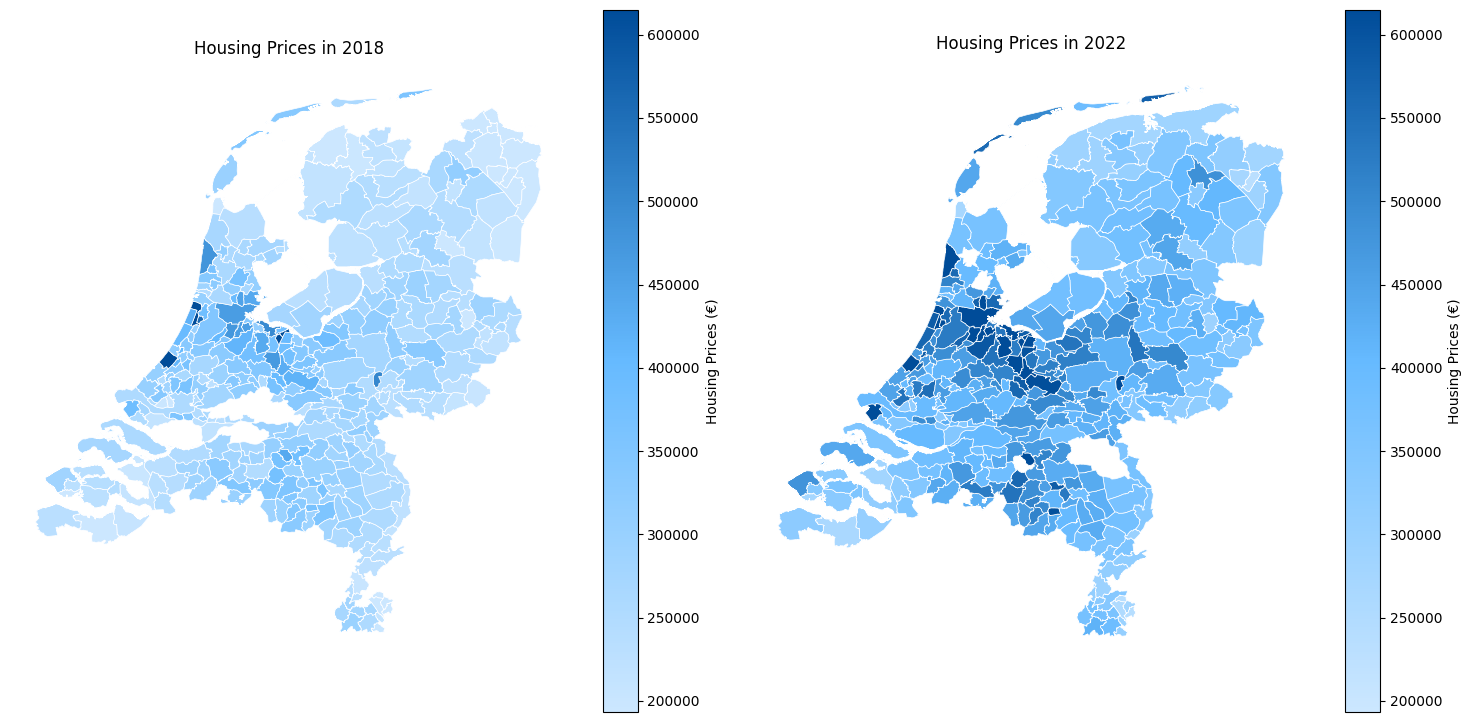

In [171]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Custom colormap using continuous lighter blue shades
cmap = mcolors.LinearSegmentedColormap.from_list("continuous_blues", ["#cce7ff", "#99d1ff", "#66baff", "#3385cc", "#004c99"])

fig, axs = plt.subplots(1, 2, figsize=(15, 12))

# Globale percentielen voor consistente schaal
global_5th_percentile = min(
    gdf_2018['verkoopprijzen'].quantile(0.05),
    gdf_2022['verkoopprijzen'].quantile(0.05)
)
global_95th_percentile = max(
    gdf_2018['verkoopprijzen'].quantile(0.95),
    gdf_2022['verkoopprijzen'].quantile(0.95)
)

# Relative housing costs for 2018
gdf_2018.plot(
    ax=axs[0],
    column='verkoopprijzen',
    legend=True,
    vmin=global_5th_percentile,
    vmax=global_95th_percentile,
    cmap=cmap,  # Use the continuous colormap
    edgecolor='white',  # Add white borders to polygons
    linewidth=0.5,  # Set thinner polygon lines
    legend_kwds={'shrink': 0.6, 'label': 'Housing Prices (€)'}  # Continuous legend label
)
axs[0].set_title('Housing Prices in 2018')
axs[0].set_aspect(1.5)  # Make the Netherlands appear longer vertically
axs[0].set_axis_off()  # Remove the axis

# Relative housing costs for 2022
gdf_2022.plot(
    ax=axs[1],
    column='verkoopprijzen',
    legend=True,
    vmin=global_5th_percentile,
    vmax=global_95th_percentile,
    cmap=cmap,  # Use the same continuous colormap
    edgecolor='white',  # Add white borders to polygons
    linewidth=0.5,  # Set thinner polygon lines
    legend_kwds={'shrink': 0.6, 'label': 'Housing Prices (€)'}  # Continuous legend label
)
axs[1].set_title('Housing Prices in 2022')
axs[1].set_aspect(1.5)  # Same aspect ratio adjustment
axs[1].set_axis_off()  # Remove the axis

plt.tight_layout()
plt.show()


Now we want to train the model on the delta of the housing prices. We will train the data on 2018 till 2022.

In [172]:
df_2022_filled

,emigratie,immigratie,leefbarometer,woningvoorraad,vergrijzing,verkoopprijzen,vertek_gm,vestiging_gm,woonquote,huishoudens,huurverhoging,gm_code,geometry,rel_verkoopprijzen,rel_woonquote
0,135.5,184.0,4.134549,25676.0,33.437569,278942.5,1200.0,1309.5,745.875000,274660.0,2.8,Appingedam,"POLYGON ((6.805827662878113 53.3170294090967, ...",NaN,NaN
1,135.5,184.0,4.118029,25676.0,33.437569,278942.5,1200.0,1309.5,745.875000,74792.0,2.8,Delfzijl,MULTIPOLYGON (((7.0783313842260345 53.26658129...,NaN,NaN
2,4860.0,9235.0,4.227829,241406.0,21.779177,353917.0,13789.0,12568.0,693.000000,11257.0,2.5,Groningen,"POLYGON ((6.480474604972311 53.24550550488332,...",56.406664,0.036088
3,135.5,184.0,4.116335,25676.0,33.437569,278942.5,1200.0,1309.5,745.875000,13712.0,2.8,Loppersum,"POLYGON ((6.739210482575176 53.38812223843702,...",NaN,NaN
4,2113.0,4229.0,4.136142,177748.0,18.294492,439053.0,9142.0,10678.0,714.000000,11612.0,2.7,Almere,MULTIPOLYGON (((5.211064108592581 52.331586002...,61.051809,-10.075567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,337.0,574.0,4.129134,77286.0,38.166865,403746.0,2278.0,3206.0,706.333333,9758.0,2.8,Hoeksche Waard,MULTIPOLYGON (((4.572305171292658 51.700072934...,NaN,NaN
351,191.0,419.0,4.129134,45958.0,41.298286,286572.0,1950.0,2189.0,720.500000,22580.0,2.5,Het Hogeland,MULTIPOLYGON (((6.290520338103406 53.339422197...,NaN,NaN
352,243.0,700.0,4.129134,55558.0,35.341146,349610.0,2128.0,2301.0,744.500000,8731.0,2.5,Westerkwartier,POLYGON ((6.231749084922092 53.255946627939615...,NaN,NaN
353,154.0,296.0,4.129134,41622.0,36.068040,276733.0,1352.0,1513.0,694.750000,20344.0,2.5,Noardeast-Fryslân,MULTIPOLYGON (((6.1758188142920964 53.34599091...,NaN,NaN


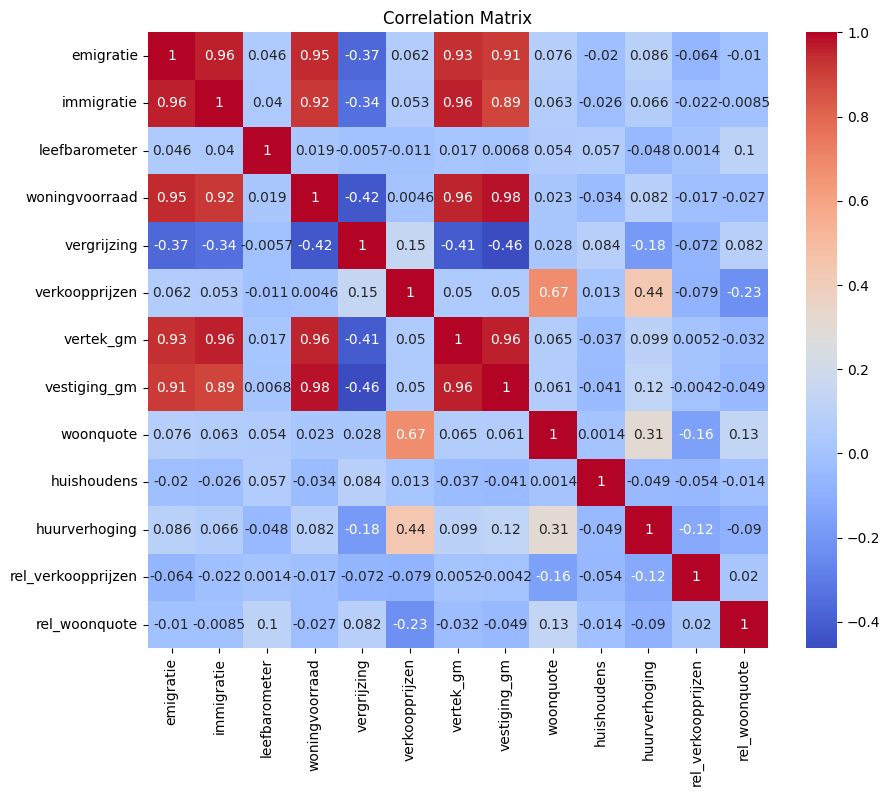

In [173]:
df_2022_filled_corr = df_2022_filled.drop(columns = ["geometry", "gm_code"])
correlation_matrix = df_2022_filled_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [174]:
# creating dependant and independant variables
Y_price = ((df_2022_filled["verkoopprijzen"]-df_2018_filled["verkoopprijzen"])/df_2018_filled["verkoopprijzen"])*100
X_price = df_2018_filled

# model creation
regr_price = LinearRegression(fit_intercept = True)

# splitting train and test data
X_train_price, X_test_price, Y_train_price, Y_test_price = train_test_split(X_price, Y_price, test_size=0.25,random_state = 12345)

# fitting data to model
regr_price.fit(X_train_price,Y_train_price)

# predicting Y
Y_pred_train_price = regr_price.predict(X_train_price)
mse_train_price = mean_squared_error(Y_train_price,Y_pred_train_price)
R2_train_price = r2_score(Y_train_price,Y_pred_train_price)

Y_pred_test_price = regr_price.predict(X_test_price)
mse_test_price  = mean_squared_error(Y_test_price, Y_pred_test_price)
R2_test_price = r2_score(Y_test_price,Y_pred_test_price)

# results
print('Results linear multiple regression model delta PRICE')
print(f'Mean Squared Error Train | Test: \t{mse_train_price:>7.4f}\t|  {mse_test_price:>7.4f}')
print(f'R2                 Train | Test: \t{R2_train_price:>7.4f}\t|  {R2_test_price:>7.4f}\n')
print('Weights')
print(f'Intercept: \t\t\t {regr_price.intercept_:>7.4f}')
for n in range(len(regr_price.coef_)):
    print(f'Weight_{X_price.keys()[n]:10s} \t\t {regr_price.coef_[n]:>7.4f}')



Results linear multiple regression model delta PRICE
Mean Squared Error Train | Test: 	140.5277	|  285.2650
R2                 Train | Test: 	 0.1275	|  -0.0159

Weights
Intercept: 			 -13.9344
Weight_emigratie  		 -0.0059
Weight_immigratie 		  0.0036
Weight_leefbarometer 		  5.7591
Weight_woningvoorraad 		 -0.0001
Weight_vergrijzing 		  0.3131
Weight_verkoopprijzen 		 -0.0001
Weight_vertek_gm  		 -0.0007
Weight_vestiging_gm 		  0.0029
Weight_woonquote  		  0.0584
Weight_huishoudens 		 -0.0000
Weight_huurverhoging 		  3.4438


### The variables "emigration," "departure_gm," "settlement_gm," "immigration" are all highly correlated with housing stock, so we take those out

In [175]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# creating dependant and independant variables
Y_price = ((df_2022_filled["verkoopprijzen"]-df_2018_filled["verkoopprijzen"])/df_2018_filled["verkoopprijzen"])*100
X_price = df_2018_filled.drop(columns = ["woningvoorraad", "vestiging_gm","vertek_gm","emigratie"])

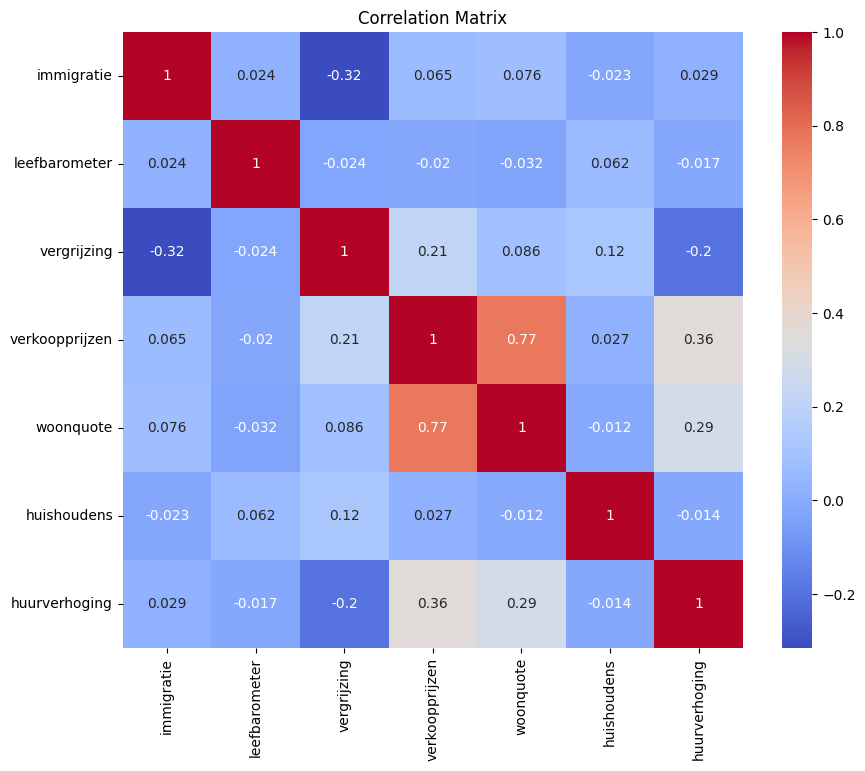

In [176]:
correlation_matrix = X_price.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [177]:
# model creation
regr_price = LinearRegression(fit_intercept = True)

# splitting train and test data
X_train_price, X_test_price, Y_train_price, Y_test_price = train_test_split(X_price, Y_price, test_size=0.25,random_state = 12345)

# fitting data to model
regr_price.fit(X_train_price,Y_train_price)

# predicting Y
Y_pred_train_price = regr_price.predict(X_train_price)
mse_train_price = mean_squared_error(Y_train_price,Y_pred_train_price)
R2_train_price = r2_score(Y_train_price,Y_pred_train_price)

Y_pred_test_price = regr_price.predict(X_test_price)
mse_test_price  = mean_squared_error(Y_test_price, Y_pred_test_price)
R2_test_price = r2_score(Y_test_price,Y_pred_test_price)

# results
print('Results linear multiple regression model delta PRICE')
print(f'Mean Squared Error Train | Test: \t{mse_train_price:>7.4f}\t|  {mse_test_price:>7.4f}')
print(f'R2                 Train | Test: \t{R2_train_price:>7.4f}\t|  {R2_test_price:>7.4f}\n')
print('Weights')
print(f'Intercept: \t\t\t {regr_price.intercept_:>7.4f}')
for n in range(len(regr_price.coef_)):
    print(f'Weight_{X_price.keys()[n]:10s} \t\t {regr_price.coef_[n]:>7.4f}')


Results linear multiple regression model delta PRICE
Mean Squared Error Train | Test: 	145.3729	|  291.5680
R2                 Train | Test: 	 0.0975	|  -0.0384

Weights
Intercept: 			 -15.2278
Weight_immigratie 		  0.0002
Weight_leefbarometer 		  5.4576
Weight_vergrijzing 		  0.2804
Weight_verkoopprijzen 		 -0.0001
Weight_woonquote  		  0.0677
Weight_huishoudens 		 -0.0000
Weight_huurverhoging 		  2.8209


In [178]:
# import shap
import shap

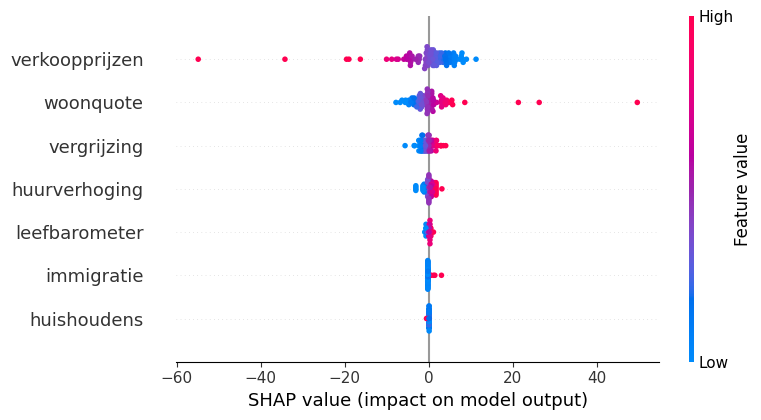

In [179]:
# SHAP uitleg
explainer = shap.LinearExplainer(regr_price, X_train_price)  # SHAP explainer for linear regression
shap_values = explainer(X_test_price)  # Calculate SHAP values

# Visualisaties met SHAP
shap.summary_plot(shap_values, X_test_price)

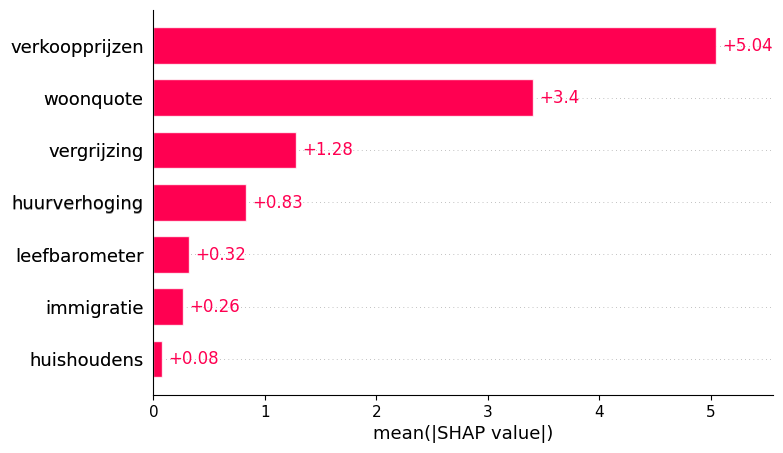

In [180]:
# What are the 3 most predictive features?
shap.plots.bar(shap_values)

R2 is now lower, so we are going to see if we can run PCA

In [181]:
X = df_2018_filled.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [182]:
pca = PCA(n_components=0.95)  # Retains components that explain 95% of the variance
X_pca = pca.fit_transform(X_scaled)
print(f"Aantal componenten: {pca.n_components_}")
print(f"Uitlegde variatie per component: {pca.explained_variance_ratio_}")
print(f"Cumulatieve variatie: {sum(pca.explained_variance_ratio_):.2f}")

Aantal componenten: 6
Uitlegde variatie per component: [0.45021181 0.18156276 0.10217034 0.09252741 0.08269488 0.05058042]
Cumulatieve variatie: 0.96


In [183]:
pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=X.columns
)
print(pca_loadings)

                     PC1       PC2       PC3       PC4       PC5       PC6
emigratie       0.431809  0.006396  0.105278 -0.057565 -0.038243 -0.092067
immigratie      0.427449 -0.004397  0.128561 -0.082027 -0.052967 -0.104400
leefbarometer   0.009109 -0.042657  0.317225  0.789589 -0.521737 -0.031087
woningvoorraad  0.439302 -0.037357  0.038796 -0.029769  0.003270 -0.077624
vergrijzing    -0.214302  0.148226  0.508721 -0.376846 -0.226151 -0.650228
verkoopprijzen  0.024643  0.655923  0.099950 -0.055349 -0.100365  0.077701
vertek_gm       0.443178 -0.021629  0.047842 -0.045978 -0.010716 -0.023744
vestiging_gm    0.435609 -0.010705  0.003689 -0.013386  0.014224  0.009170
woonquote       0.042475  0.628248  0.036108 -0.062000 -0.130048  0.420195
huishoudens    -0.025711  0.022502  0.648659  0.217452  0.712692  0.150780
huurverhoging   0.050982  0.385661 -0.420833  0.408806  0.370318 -0.587241


In [184]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import shap

# Splits de PCA-data
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y_price, test_size=0.25, random_state=123)

# Train een regressiemodel
VerkoopPrijsPredictor = LinearRegression()
VerkoopPrijsPredictor.fit(X_train, y_train)

# Voorspellingen
y_pred_train = VerkoopPrijsPredictor.predict(X_train)
y_pred_test = VerkoopPrijsPredictor.predict(X_test)

# Evaluatiemetrics
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

# Print evaluatieresultaten
print(f"R² Train: {r2_train:.4f}")
print(f"R² Test: {r2_test:.4f}")
print(f"MSE Train: {mse_train:.4f}")
print(f"MSE Test: {mse_test:.4f}")


R² Train: 0.0261
R² Test: -0.1789
MSE Train: 221.8426
MSE Test: 83.7203


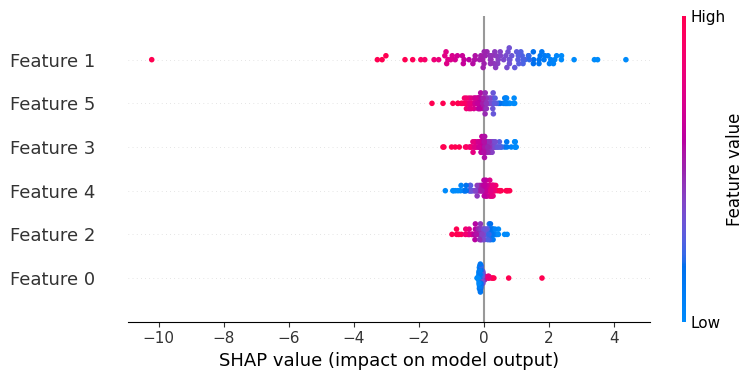

In [185]:
# SHAP uitleg
explainer = shap.LinearExplainer(VerkoopPrijsPredictor, X_train)  # SHAP explainer voor lineaire regressie
shap_values = explainer(X_test)  # SHAP-waarden berekenen

# Visualisaties met SHAP
shap.summary_plot(shap_values, X_test)

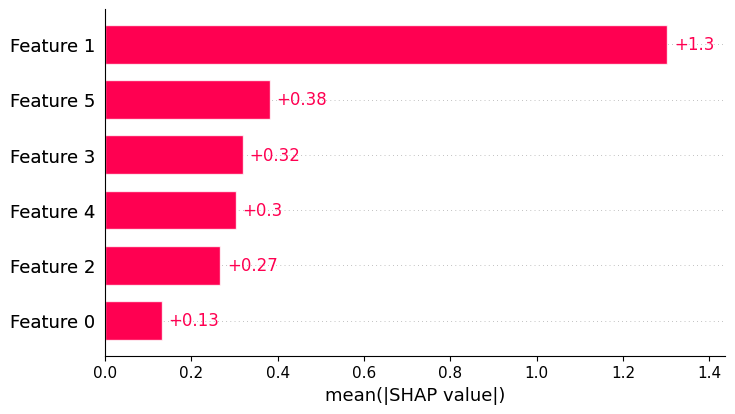

In [186]:
# What are the 3 most predictive features?
shap.plots.bar(shap_values)

PCA not needed with randomforestregressor because it is not sensitive to multicollinearity or scale of variables.

In [187]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Y (delta sales prices) and X (2018 variables)
Y_price = ((df_2022_filled["verkoopprijzen"]-df_2018_filled["verkoopprijzen"])/df_2018_filled["verkoopprijzen"])*100
X_price = df_2018_filled

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_price, Y_price, test_size=0.25, random_state=42)

# Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

# Voorspellingen
Y_pred_train = model.predict(X_train)  # Predictions on training set
Y_pred_test = model.predict(X_test)    # Predictions on test set

# Evaluatiemetriek
r2_train = r2_score(Y_train, Y_pred_train)
r2_test = r2_score(Y_test, Y_pred_test)
mse_train = mean_squared_error(Y_train, Y_pred_train)
mse_test = mean_squared_error(Y_test, Y_pred_test)

# Resultaten afdrukken
print(f"R² Train: {r2_train:.4f}")
print(f"R² Test: {r2_test:.4f}")
print(f"MSE Train: {mse_train:.4f}")
print(f"MSE Test: {mse_test:.4f}")


R² Train: 0.8637
R² Test: -0.1049
MSE Train: 27.9843
MSE Test: 164.4022


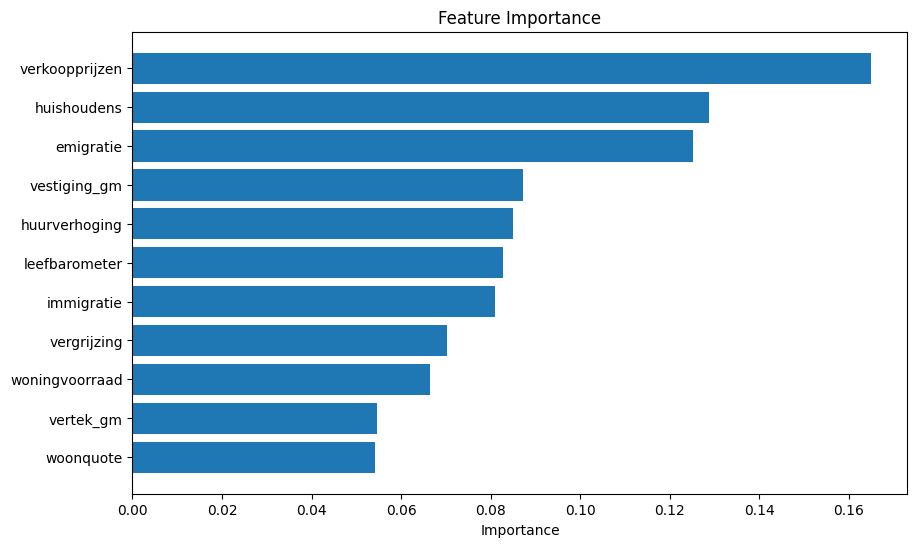

In [188]:
# Importance of features
feature_importances = model.feature_importances_
sorted_indices = feature_importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_price.columns[sorted_indices], feature_importances[sorted_indices])
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()

R2 train is much higher than test, so he overfit very much. Therefore perform grid search.

In [189]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
# }

# grid_search = GridSearchCV(
#     estimator=RandomForestRegressor(random_state=42),
#     param_grid=param_grid,
#     scoring='r2',
#     cv=5,
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train)
# print("Beste parameters:", grid_search.best_params_)

In [190]:
# Random Forest Model
# Y (delta verkoopprijzen) en X (variabelen van 2018)
Y_price = ((df_2022_filled["verkoopprijzen"]-df_2018_filled["verkoopprijzen"])/df_2018_filled["verkoopprijzen"])*100
X_price = df_2018_filled

model = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=20, min_samples_leaf=2, min_samples_split=5)
model.fit(X_train, Y_train)

# Voorspellingen
Y_pred_train = model.predict(X_train)  # Voorspellingen op trainingsset
Y_pred_test = model.predict(X_test)    # Voorspellingen op testset

# Evaluatiemetrics
r2_train = r2_score(Y_train, Y_pred_train)
r2_test = r2_score(Y_test, Y_pred_test)
mse_train = mean_squared_error(Y_train, Y_pred_train)
mse_test = mean_squared_error(Y_test, Y_pred_test)

# Resultaten printen
print(f"R² Train: {r2_train:.4f}")
print(f"R² Test: {r2_test:.4f}")
print(f"MSE Train: {mse_train:.4f}")
print(f"MSE Test: {mse_test:.4f}")


R² Train: 0.7437
R² Test: -0.0428
MSE Train: 52.6216
MSE Test: 155.1550


In [191]:
# print("Beste hyperparameters:", grid_search.best_params_)

### To explain our method, we will make predictions for 2026 using the regression model. These results cannot be interpreted because the data is not optimal, and because of this all our models did not score well enough.

In [192]:
df_predict_2022 = df_2022_filled.drop(columns = ["gm_code", "geometry","rel_verkoopprijzen","rel_woonquote"])

In [193]:
# Applying PCA (use the previously trained PCA)
X_new = df_predict_2022

X_new_scaled = scaler.transform(X_new)  # Scale the new data
X_new_pca = pca.transform(X_new_scaled)  # PCA-transformatie

In [194]:
# Predicting with new data
Y_pred_new = VerkoopPrijsPredictor.predict(X_new_pca)

df_2026 = pd.DataFrame(Y_pred_new, columns=['rel_verkoopprijzen'])
df_2026['gm_naam'] = df_predictions['gm_naam']
df_2026['geometry'] = df_woningvoorraad['geometry']

In [195]:
df_2026['geometry'] = df_2026['geometry'].apply(wkt.loads)
gdf_2026 = gpd.GeoDataFrame(df_2026, geometry='geometry')


In [196]:
gdf_2026

,rel_verkoopprijzen,gm_naam,geometry
0,46.096526,Appingedam,"POLYGON ((6.80583 53.31703, 6.80588 53.31704, ..."
1,47.029310,Delfzijl,"MULTIPOLYGON (((7.07833 53.26658, 7.07826 53.2..."
2,47.779759,Groningen,"POLYGON ((6.48047 53.24551, 6.48050 53.24579, ..."
3,47.283791,Loppersum,"POLYGON ((6.73921 53.38812, 6.73925 53.38815, ..."
4,46.518195,Almere,"MULTIPOLYGON (((5.21106 52.33159, 5.21106 52.3..."
...,...,...,...
350,46.452182,Hoeksche Waard,"MULTIPOLYGON (((4.57231 51.70007, 4.57053 51.6..."
351,47.562239,Het Hogeland,"MULTIPOLYGON (((6.29052 53.33942, 6.29052 53.3..."
352,46.367208,Westerkwartier,"POLYGON ((6.23175 53.25595, 6.23176 53.25599, ..."
353,48.115821,Noardeast-Fryslân,"MULTIPOLYGON (((6.17582 53.34599, 6.17582 53.3..."


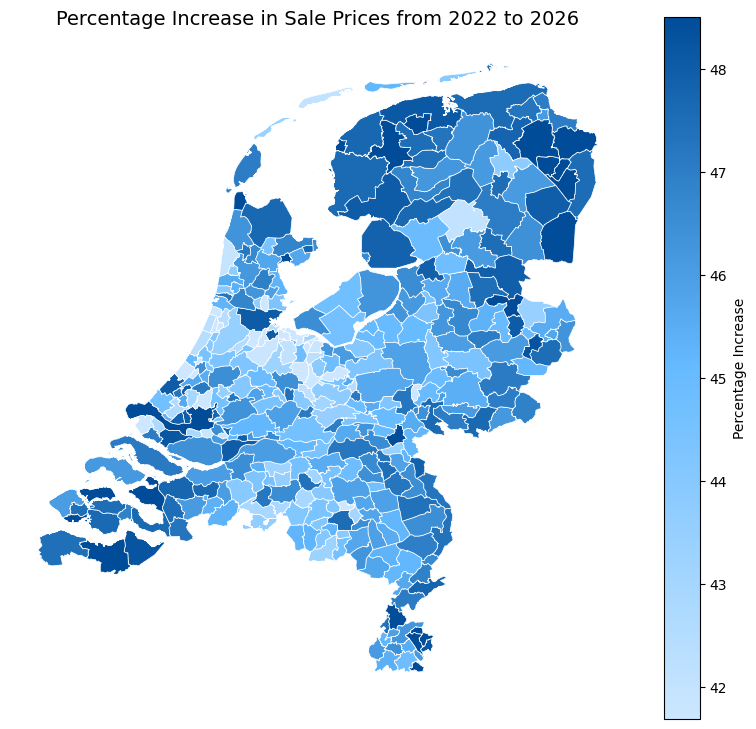

In [197]:
# Custom colormap using continuous lighter blue shades
cmap = mcolors.LinearSegmentedColormap.from_list("continuous_blues", ["#cce7ff", "#99d1ff", "#66baff", "#3385cc", "#004c99"])

# Percentiles for color scale
price_5th_percentile = gdf_2026['rel_verkoopprijzen'].quantile(0.05)
price_95th_percentile = gdf_2026['rel_verkoopprijzen'].quantile(0.95)

# Plotting percentage increase in sale prices with continuous color legend
fig, ax = plt.subplots(figsize=(8, 12))  # Set dimensions to make it taller and less wide
gdf_2026.plot(
    ax=ax,
    column='rel_verkoopprijzen',
    legend=True,
    vmin=price_5th_percentile,
    vmax=price_95th_percentile,
    cmap=cmap,  # Use the continuous colormap
    edgecolor='white',  # Add white borders to polygons
    linewidth=0.5,  # Set thinner polygon lines
    legend_kwds={
        'shrink': 0.6,  # Adjust the size of the legend
        'label': 'Percentage Increase'  # Update label to reflect percentage increase
    }
)

# Set title and remove axes
ax.set_title('Percentage Increase in Sale Prices from 2022 to 2026', fontsize=14)
ax.set_aspect(1.5)  # Make the map longer vertically
ax.set_axis_off()  # Remove the axis for a cleaner look

plt.tight_layout()
plt.show()

In [198]:
# Print max verkoopprijzen row
df_2026[df_2026['rel_verkoopprijzen'] == df_2026['rel_verkoopprijzen'].max()]

,rel_verkoopprijzen,gm_naam,geometry
195,50.399183,Tholen,MULTIPOLYGON (((4.153239926472222 51.606108283...


In [199]:
# Print min verkoopprijzen row
df_2026[df_2026['rel_verkoopprijzen'] == df_2026['rel_verkoopprijzen'].min()]

,rel_verkoopprijzen,gm_naam,geometry
114,31.461758,Bloemendaal,POLYGON ((4.5914590097409915 52.39136265439738...


## Save output

In [200]:
if SAVE_OUTPUT:
    df.to_csv(Path(SHAREDRIVE_PATH) / OUTPUT_DATA_PATH, sep = ';', index = False)

## Watermark

In [201]:
!python -m pip install watermark --quiet

In [202]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [203]:
%watermark

Last updated: 2025-01-27T11:13:39.954767+01:00

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.17.2

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [204]:
%watermark --iversions

shap      : 0.44.0
numpy     : 1.26.1
matplotlib: 3.8.1
shapely   : 2.0.2
seaborn   : 0.13.0
pandas    : 2.1.2
branca    : 0.6.0
sklearn   : 1.3.2
geopandas : 0.14.0



In [205]:
!lsb_release -a

'lsb_release' is not recognized as an internal or external command,
operable program or batch file.
